# Check resource availability and Import relavent packages

In [1]:
# check GPU availability
!nvidia-smi

Sat Apr  6 19:16:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                On  | 00000000:1B:00.0 Off |                  Off |
| 33%   41C    P8              28W / 260W |      1MiB / 24576MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision as tv
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import time
import os
import copy
import requests
import io
import csv
import random


plt.ion()   # interactive mode

import timm 
from tqdm import tqdm

In [3]:
# Check if CUDA (GPU support) is available
is_cuda_available = torch.cuda.is_available()
print("Is CUDA (GPU) available:", is_cuda_available)

# If CUDA is available, print the GPU name(s)
if is_cuda_available:
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPU(s) available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Is CUDA (GPU) available: True
Number of GPU(s) available: 1
GPU 0: Quadro RTX 6000


In [4]:
all_vit_models = timm.list_models('*vit*', pretrained=True)
all_vit_models

['convit_base.fb_in1k',
 'convit_small.fb_in1k',
 'convit_tiny.fb_in1k',
 'crossvit_9_240.in1k',
 'crossvit_9_dagger_240.in1k',
 'crossvit_15_240.in1k',
 'crossvit_15_dagger_240.in1k',
 'crossvit_15_dagger_408.in1k',
 'crossvit_18_240.in1k',
 'crossvit_18_dagger_240.in1k',
 'crossvit_18_dagger_408.in1k',
 'crossvit_base_240.in1k',
 'crossvit_small_240.in1k',
 'crossvit_tiny_240.in1k',
 'davit_base.msft_in1k',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k',
 'efficientvit_b0.r224_in1k',
 'efficientvit_b1.r224_in1k',
 'efficientvit_b1.r256_in1k',
 'efficientvit_b1.r288_in1k',
 'efficientvit_b2.r224_in1k',
 'efficientvit_b2.r256_in1k',
 'efficientvit_b2.r288_in1k',
 'efficientvit_b3.r224_in1k',
 'efficientvit_b3.r256_in1k',
 'efficientvit_b3.r288_in1k',
 'efficientvit_l1.r224_in1k',
 'efficientvit_l2.r224_in1k',
 'efficientvit_l2.r256_in1k',
 'efficientvit_l2.r288_in1k',
 'efficientvit_l2.r384_in1k',
 'efficientvit_l3.r224_in1k',
 'efficientvit_l3.r256_in1k',
 'efficientvit_l3.r320_in1

# Create Dataset

In [89]:
from timm.data import create_dataset, create_loader

In [90]:
# config 
input_size = 3, 224, 224
img_size = 224
num_classes = 15
batch_size = 32

interpolation = 'bicubic'
DEFAULT_CROP_PCT = 1

In [91]:
train_dir = '../Dataset/images/train_binary'
val_dir = '../Dataset/images/validation_binary'

In [92]:
class_map = {
        'Normal': 0,
        'Cases': 1
        }

In [93]:
# create the train and eval datasets
train_dataset = create_dataset(name='', root=train_dir, split='train', is_training=True, batch_size=batch_size, class_map = class_map)
val_dataset = create_dataset(name='', root=val_dir, split='validation', is_training=False, batch_size=batch_size, class_map = class_map)
train_len, val_len = len(train_dataset), len(val_dataset)
print('Training set size: ' + str(train_len))
print('Validation set size: ' + str(val_len))

Training set size: 75770
Validation set size: 10754


In [94]:
# resize images to fit the input of pretrained model
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    #transforms.CenterCrop((224*3, 224*3)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = transform
val_dataset.transform = transform

# Visual one image

In [95]:
import cv2 as cv
from PIL import Image
def find_a_image(path, label_map):
    img_name = random.choice(os.listdir(path))
    print(img_name)
    print(label_map[img_name])
    return img_name

In [96]:
# load label to give detail of diagnosis while visualise the image
train_label = pd.read_csv('../Dataset/train_label.csv', index_col=False)
val_label = pd.read_csv('../Dataset/val_label.csv', index_col=False)
train_label_map = train_label.set_index('FileName').to_dict(orient='index')
val_label_map = val_label.set_index('FileName').to_dict(orient='index')

00025169_005.png
{'Atelectasis': 0, 'Cardiomegaly': 0, 'Effusion': 0, 'Infiltration': 0, 'Mass': 1, 'Nodule': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Consolidation': 0, 'Edema': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Pleural_Thickening': 1, 'Hernia': 0}


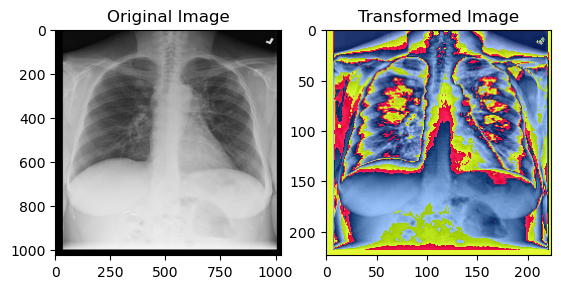

In [97]:
# visualise a Cases image
im_path = '../Dataset/images/train_binary/Cases'

img = Image.open(im_path + '/' + find_a_image(im_path, train_label_map))
transformed_image = transform(img)
transformed_image_pil = transforms.ToPILImage()(transformed_image)

fig, axs = plt.subplots(1, 2)

# Display the first image in the first subplot
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')

# Display the second image in the second subplot
axs[1].imshow(transformed_image_pil)
axs[1].set_title('Transformed Image')

# Show the plot
plt.show()

00029072_000.png
{'Atelectasis': 0, 'Cardiomegaly': 0, 'Effusion': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Consolidation': 0, 'Edema': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Pleural_Thickening': 0, 'Hernia': 0}


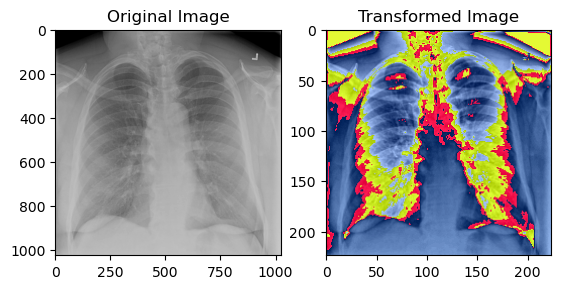

In [98]:
# Visulise a Normal image
im_path = '../Dataset/images/train_binary/Normal'

img = Image.open(im_path + '/' + find_a_image(im_path, train_label_map))
transformed_image = transform(img)
transformed_image_pil = transforms.ToPILImage()(transformed_image)


fig, axs = plt.subplots(1, 2)

# Display the first image in the first subplot
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')

# Display the second image in the second subplot
axs[1].imshow(transformed_image_pil)
axs[1].set_title('Transformed Image')

# Show the plot
plt.show()

# create data loader

In [121]:
# create data loaders 
loader_train = create_loader(
        train_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=True,
        interpolation=interpolation,
        num_workers=2)

loader_val = create_loader(
        val_dataset,
        input_size=input_size,
        batch_size=batch_size,
        is_training=False,
        interpolation=interpolation,
        crop_pct=DEFAULT_CROP_PCT)

In [100]:
# check if labels are loaded as defined
train_dataset.reader.class_to_idx

{'Normal': 0, 'Cases': 1}

In [101]:
# check how many images for each class. confirm if this number is correct to make sure images are loaded properly
class_images_num = dict(zip(class_map.values(),[0]*15))
for i in range(len(train_dataset.reader)):
    _, class_idx = train_dataset.reader[i]
    class_images_num[class_idx] += 1

class_images_num

{0: 44379, 1: 31391}

In [102]:
44379 + 31391

75770

# Model

In [103]:
#model_name = 'vit_base_r50_s16_224.orig_in21k'

In [104]:
model_name = 'vit_base_patch16_224.orig_in21k'

In [105]:
#model_name = 'resnet50.a1_in1k'

In [106]:
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes) #, img_size=img_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # if print 'cuda' then GPU is used
model.to(device)

cuda


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# check if data on GPU

In [107]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Move model to GPU
    model.cuda()

    # Move data tensors to GPU
    #data_tensor = data_tensor.cuda()

    # Check the device of model parameters
    for name, param in model.named_parameters():
        print(f"Parameter {name} is on device: {param.device}")

    # Check the device of data tensor
    print(f"loader_train is on device: {loader_train.device}")
    print(f"loader_val is on device: {loader_val.device}")

else:
    print("CUDA (GPU) is not available.")

Parameter cls_token is on device: cuda:0
Parameter pos_embed is on device: cuda:0
Parameter patch_embed.proj.weight is on device: cuda:0
Parameter patch_embed.proj.bias is on device: cuda:0
Parameter blocks.0.norm1.weight is on device: cuda:0
Parameter blocks.0.norm1.bias is on device: cuda:0
Parameter blocks.0.attn.qkv.weight is on device: cuda:0
Parameter blocks.0.attn.qkv.bias is on device: cuda:0
Parameter blocks.0.attn.proj.weight is on device: cuda:0
Parameter blocks.0.attn.proj.bias is on device: cuda:0
Parameter blocks.0.norm2.weight is on device: cuda:0
Parameter blocks.0.norm2.bias is on device: cuda:0
Parameter blocks.0.mlp.fc1.weight is on device: cuda:0
Parameter blocks.0.mlp.fc1.bias is on device: cuda:0
Parameter blocks.0.mlp.fc2.weight is on device: cuda:0
Parameter blocks.0.mlp.fc2.bias is on device: cuda:0
Parameter blocks.1.norm1.weight is on device: cuda:0
Parameter blocks.1.norm1.bias is on device: cuda:0
Parameter blocks.1.attn.qkv.weight is on device: cuda:0
Para

In [108]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [109]:
# weight_decay
skip = {}
if hasattr(model, 'no_weight_decay'):
    skip = model.no_weight_decay()
parameters = add_weight_decay(model, 0.0001, skip)
weight_decay = 0.

In [110]:
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(parameters, momentum=0.9, nesterov=True, lr=0.01, weight_decay=weight_decay)

In [111]:
from timm.scheduler import StepLRScheduler
# setup learning rate schedule and starting epoch
lr_scheduler = StepLRScheduler(optimizer, decay_t=30, decay_rate=0.1,
               warmup_lr_init=0.0001, warmup_t=3, noise_range_t=None, noise_pct=0.67,
               noise_std=1., noise_seed=42)

In [112]:
def eval_fn(model, eval_data):
    model.eval()

    total_correct = 0
    total_samples = 0
    
    preds = []
    with torch.no_grad():
        for images, labels in eval_data:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
    accuracy = total_correct / total_samples
    return accuracy

In [113]:
num_epochs = 10
losses = [[]]
accus_train = [[]]
accus_val = []
learning_rates = []

In [114]:
from datetime import datetime
current_datetime = datetime.now()
date_time = str(current_datetime)[:-7].replace('-','').replace(':','').replace(' ','_')

In [115]:
model_save_path = f'model_result/model_pth/MODEL_FINETUNE_{model_name}_{date_time}.pth'
model_save_path

'model_result/model_pth/MODEL_FINETUNE_vit_base_patch16_224.orig_in21k_20240406_195953.pth'

In [116]:
def output_log_writer(s, end='\r'):
    with open(f'model_result/log/output_{model_name}_{date_time}.txt', 'a') as output_file:
        output_file.write(s+'\n')
        print(s,end,flush=True)

In [ ]:
for epoch in range(num_epochs):
    output_log_writer(f'-------------------------------[Epoch {epoch+1}]---------------------------------')
    output_log_writer(f'[Epoch {epoch+1}] Training...', end='')
    for batch, (images, labels) in enumerate(loader_train):
        print('=', end='')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses[-1].append(loss.item()) # all losses for this epoch

        with torch.no_grad():
            accus_train[-1].append(torch.sum(torch.max(outputs, dim=1)[1] == labels)) # all train accuracy for this epoch
    
    
    print('\r')
    output_log_writer(f'[Epoch {epoch+1}] Computing Train Measurement...')
    # save all batches loss
    with open(f'model_result/measurement/batch_loss_{model_name}_{date_time}.csv', 'w') as b_loss_file:
        writer = csv.writer(b_loss_file)
        writer.writerow([epoch] + losses[-1])
    
    # compute total loss after this epoch 
    losses[-1] = sum(losses[-1]) 
    # save epoch loss
    with open(f'model_result/measurement/epoch_loss_{model_name}_{date_time}.csv', 'w') as e_loss_file:
        writer = csv.writer(e_loss_file)
        writer.writerow([epoch, losses[-1]])
    losses.append([])
    
    # compute average accuracy after this epoch
    accus_train[-1] = sum(accus_train[-1]) / train_len 
    with open(f'model_result/measurement/acc_train_{model_name}_{date_time}.csv', 'w') as acc_train_file:
        writer = csv.writer(acc_train_file)
        writer.writerow([epoch, float(accus_train[-1])])
    accus_train.append([])

    # step LR for next epoch
    output_log_writer(f'[Epoch {epoch+1}] Update Learning Rate...')
    lr = lr_scheduler.get_lr()
    learning_rates.append(lr)
    lr_scheduler.step(epoch + 1)
    # save learning rate for this epoch
    with open(f'model_result/measurement/learning_rate_{model_name}_{date_time}.csv', 'w') as lr_file:
        writer = csv.writer(lr_file)
        writer.writerow([epoch, learning_rates[-1]])
    
    # compute validation accuracy
    output_log_writer(f'[Epoch {epoch+1}] Computing Validation Measurement...')
    accus_val.append(eval_fn(model, loader_val))
    with open(f'model_result/measurement/acc_val_{model_name}_{date_time}.csv', 'w') as acc_val_file:
        writer = csv.writer(acc_val_file)
        writer.writerow([epoch, accus_val[-1]])
    
    model.train() # slowest line

    
    # print evaludation
    output_log_writer(f'[Epoch {epoch+1}] loss={losses[-2]:.2e} train accu={accus_train[-2]:.2%} validation accu={accus_val[-1]:.2%}')
    
    # save output log
    
        
    # save model checkpoint
    ckpt_save_path = f'model_result/model_checkpoint/MODEL_CKPT_{epoch}_{model_name}_{date_time}.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses[-2],
            }, ckpt_save_path)
    output_log_writer(f'[Epoch {epoch+1}] Model checkpoint is saved.')

        
torch.save(model, model_save_path)
output_log_writer('\n\nFinal model saved. Training Finished.')

-------------------------------[Epoch 1]--------------------------------- 
[Epoch 1] Training... 